# Islamophhobia Detection with mBERT using Keras and TensorFlow 2



In [1]:
!nvidia-smi

Thu Sep 17 23:26:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 44kB/s 


In [3]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [4]:
!pip install tqdm

In [5]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 3.5MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=f8006648a0f3011a32597b783179f9ad45ebac011d3707a8ca423d078c3c90e5
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=5cb825fa0241af476be9233612a08973ce8e8f5d93f9a680ab2be9fce516fbaa
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=09b969858151bdfa8f4d3017199775489cd9864b7c8cf3e062b71295293e3b74
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [6]:
!pip install googletrans

     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 962kB 20.4MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=8f21e5f712ea754450938237972aa55b8b273314b0695132b154f53e2b65fd7a
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=49b2de0d684037f9fcd90c1ae0583d30952df15ed4e84056d99d6a9ab233e753
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [7]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 7.7MB/s 


In [8]:
!pip install googletrans

In [9]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator
translator = Translator()

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [10]:
# Hindi translated data
# !gdown --id 1zJVv_Ldh5vhDmw2mJSrgMcKlLt1fWyBw --output data-task1.csv

# Hindi data
!gdown --id 1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW --output data-task3.csv

Downloading...
From: https://drive.google.com/uc?id=1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW
To: /content/data-task3.csv
100% 1.63M/1.63M [00:00<00:00, 104MB/s]


In [11]:
orig_df = pd.read_csv('data-task3.csv', 
                   delimiter=',')
orig_df.columns = ['Text', 'Label']
orig_df.head(15)
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)

In [12]:
orig_df.Text[3]


"'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के गेट पर आधा नंगा होकर किया प्रदर्शन  पप्पू यादव ने बुलंद की\\xa0आवाज"

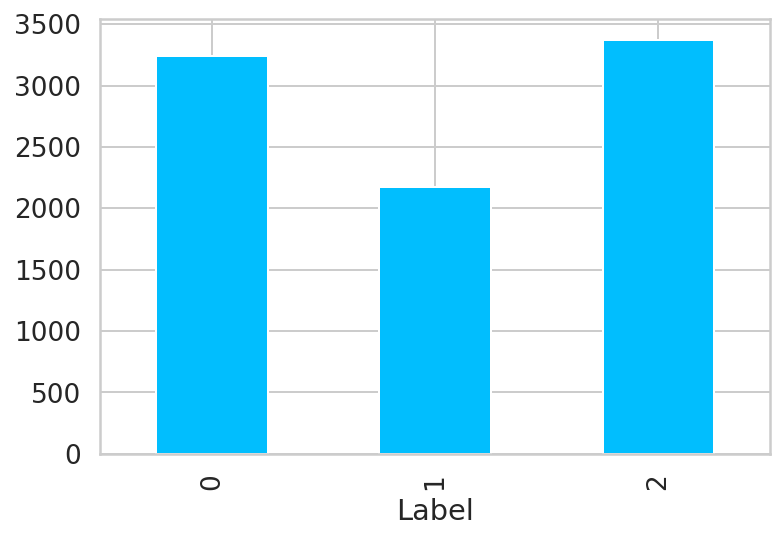

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
orig_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [14]:


# For entire dataset sentences for each labels 
orig_df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

In [15]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [16]:
new_text, new_label = balanceClasses(orig_df['Text'], orig_df['Label'])

In [17]:
data_df = pd.DataFrame(new_text)
data_df.columns = ['Text']
data_df['Label'] = new_label
data_df = pd.concat([orig_df, data_df])

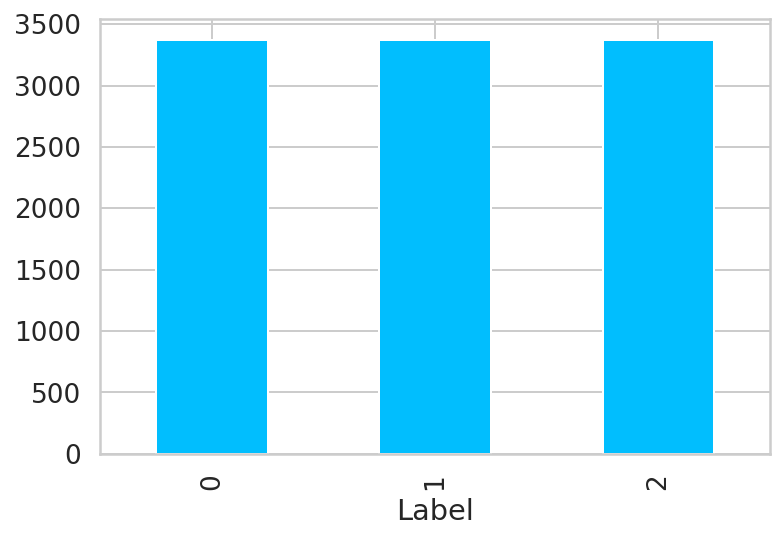

In [18]:
fig1 = plt.figure(figsize=(6,4))
data_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [19]:
df = data_df

In [20]:
df.Label.value_counts()

2    3375
0    3374
1    3374
Name: Label, dtype: int64

In [21]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,'@BushraAnjum_ मेरी तरफ से आपको बहुत-बहुत तहे ...,1
1,'@kpmaurya1 नारी शक्ति जिंदाबाद जिंदाबाद,0
2,'जेहादी सोच थी उसकी कोई शायर का काम थोड़ी था।...,2
3,'@naaz786nice जुम्मा के दिन नमाज़ में ऐसे लोगो...,1
4,'अब खुब जमेगा रंग जब मिल बैठेंगे तीन यार संग। ...,0
...,...,...
10118,'@aschandailBJP शानदार👏 जिंदाबाद भइया,0
10119,@Swamy29 सर वीडियो बन गया हैं जल्दी उपलोड कर ...,2
10120,'तस्वीरों में देखें कैसे रांची के राजकुमार बन...,0
10121,'@ZeeNewsHindi हज़ारों मुसलमानों ने रमज़ान में...,1


Data Preprocessing

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [23]:
df.head()

,Text,Label
0,'@BushraAnjum_ मेरी तरफ से आपको बहुत-बहुत तहे ...,1
1,'@kpmaurya1 नारी शक्ति जिंदाबाद जिंदाबाद,0
2,'जेहादी सोच थी उसकी कोई शायर का काम थोड़ी था।...,2
3,'@naaz786nice जुम्मा के दिन नमाज़ में ऐसे लोगो...,1
4,'अब खुब जमेगा रंग जब मिल बैठेंगे तीन यार संग। ...,0


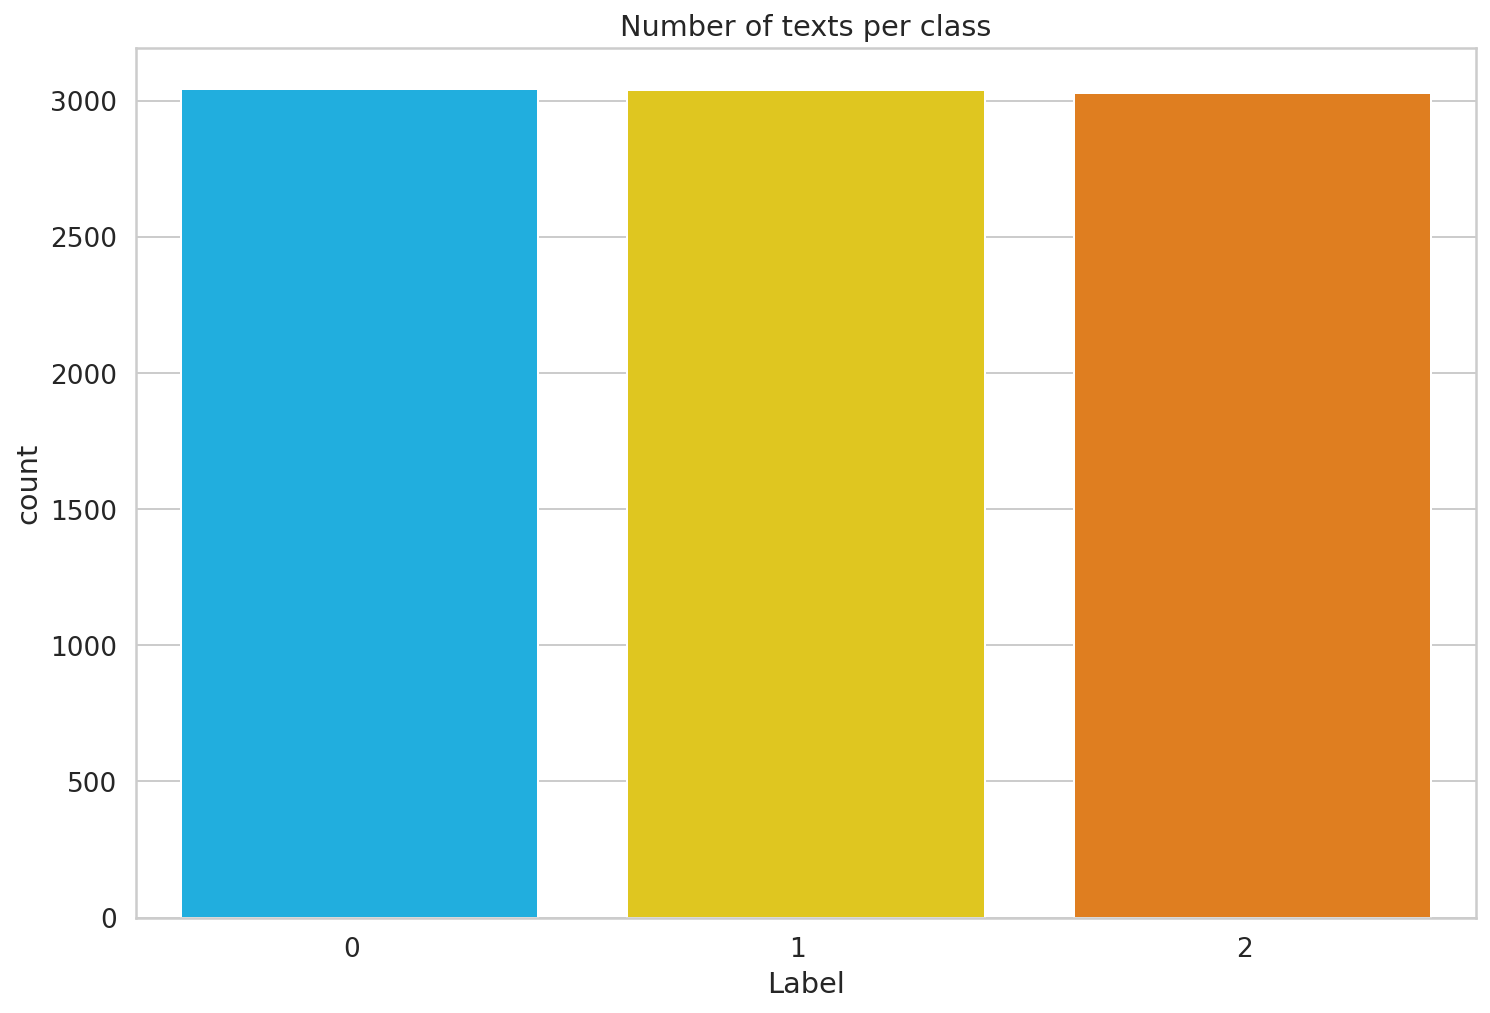

In [24]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='right');

# Islamophhobia Detection with mBERT


In [25]:
!gdown --id 1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a --output multi_cased_L-12_H-768_A-12.zip

Downloading...
From: https://drive.google.com/uc?id=1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a
To: /content/multi_cased_L-12_H-768_A-12.zip
663MB [00:08, 80.0MB/s]


In [26]:
!unzip multi_cased_L-12_H-768_A-12

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [27]:
os.makedirs("model", exist_ok=True)

In [28]:
!mv multi_cased_L-12_H-768_A-12/ model

In [29]:
bert_model_name="multi_cased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [30]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [31]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [32]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [33]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

9110it [00:04, 1957.31it/s]
1013it [00:00, 1988.67it/s]


max seq_len 167


In [34]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f31c7d46208> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [35]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [36]:


history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=5
)

Epoch 1/5
257/257 [==============================] - 156s 606ms/step - loss: 0.7530 - acc: 0.7875 - val_loss: 0.6136 - val_acc: 0.9341
Epoch 2/5
257/257 [==============================] - 150s 585ms/step - loss: 0.6055 - acc: 0.9451 - val_loss: 0.6079 - val_acc: 0.9418
Epoch 3/5
257/257 [==============================] - 151s 586ms/step - loss: 0.5997 - acc: 0.9517 - val_loss: 0.6115 - val_acc: 0.9407
Epoch 4/5
257/257 [==============================] - 151s 586ms/step - loss: 0.6030 - acc: 0.9473 - val_loss: 0.6165 - val_acc: 0.9319
Epoch 5/5
257/257 [==============================] - 150s 584ms/step - loss: 0.5952 - acc: 0.9556 - val_loss: 0.6021 - val_acc: 0.9484


## Evaluation

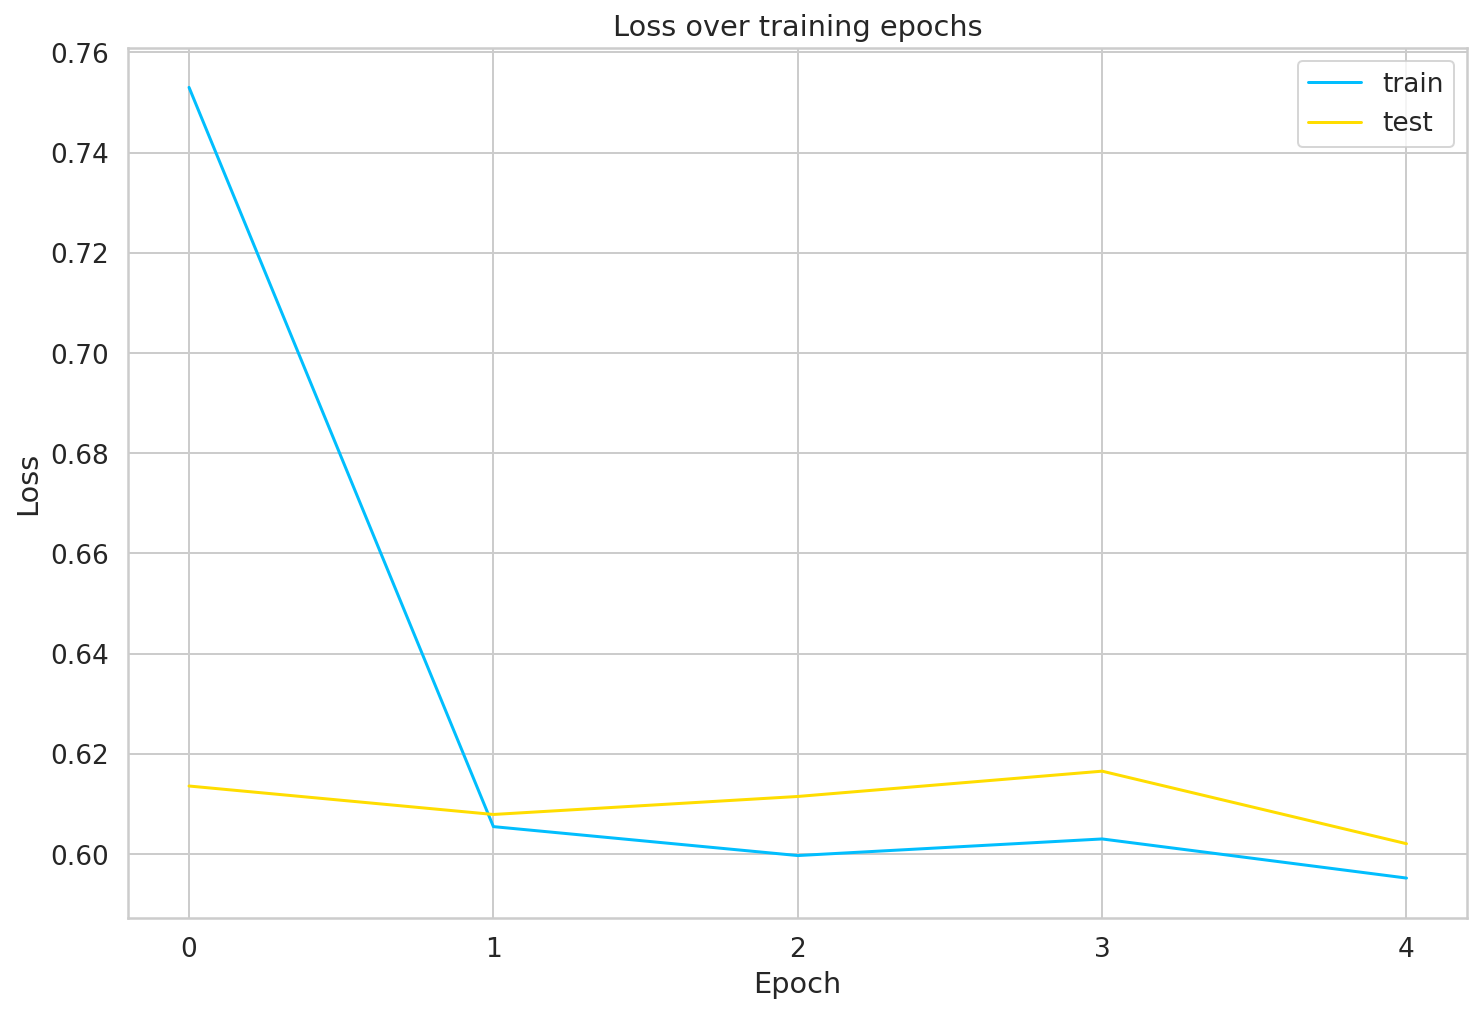

In [37]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

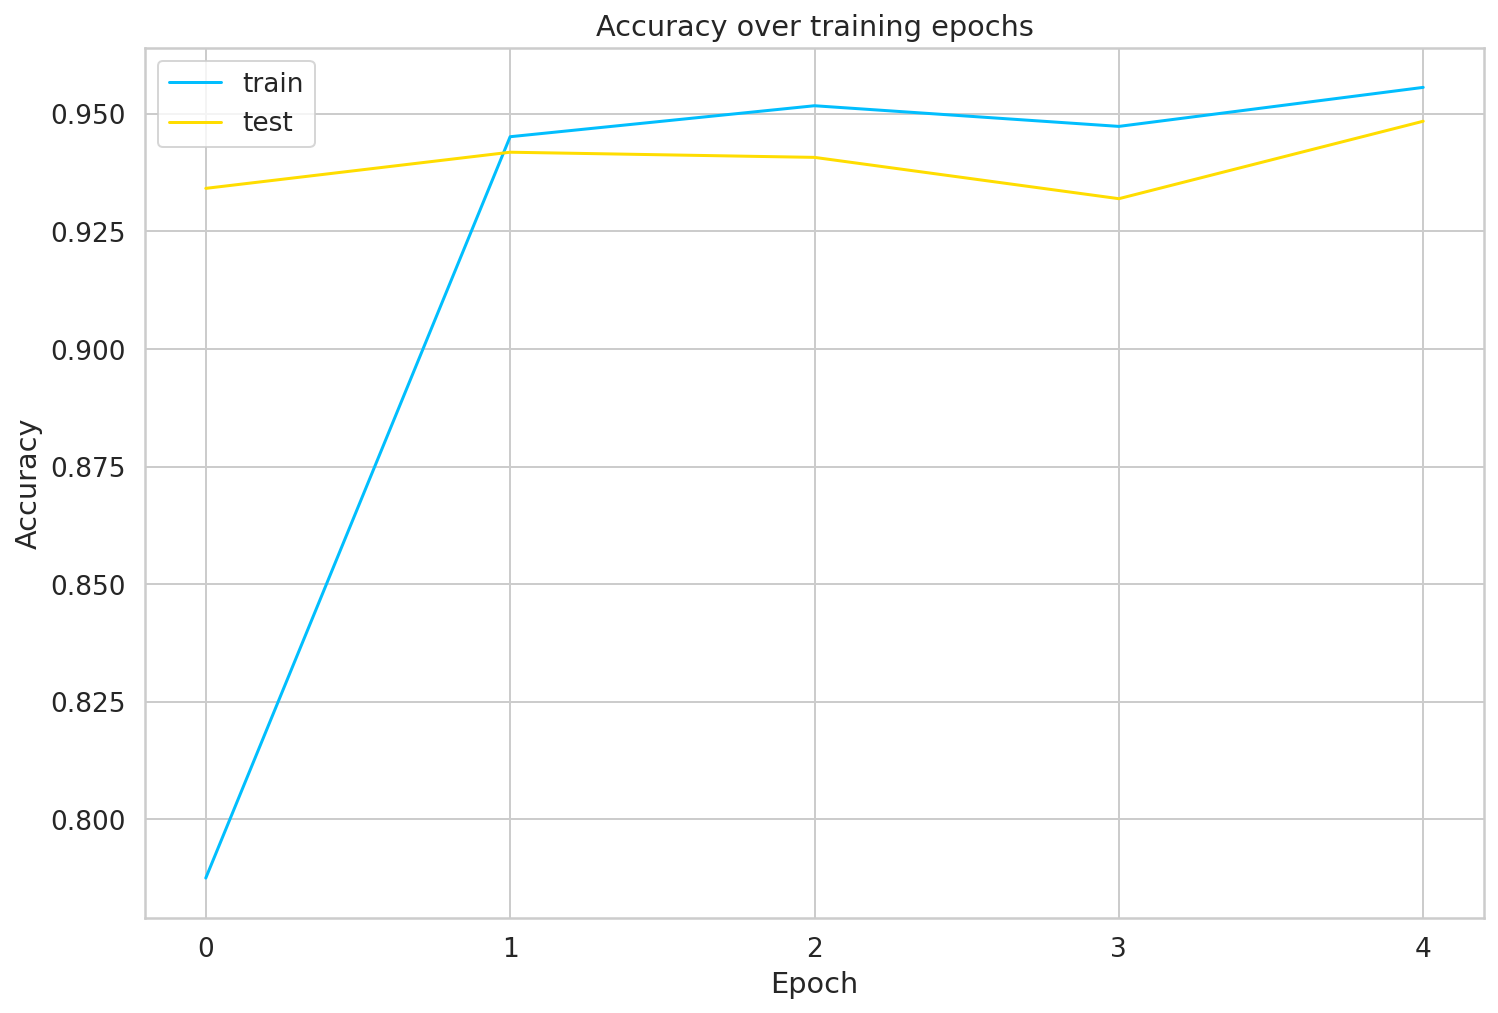

In [38]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [39]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

32/32 [==============================] - 3s 104ms/step - loss: 0.5999 - acc: 0.9526
train acc 0.9620197415351868
test acc 0.9526159763336182


In [40]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [41]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       336
           1       0.98      0.92      0.95       332
           2       0.96      0.95      0.96       345

    accuracy                           0.95      1013
   macro avg       0.95      0.95      0.95      1013
weighted avg       0.95      0.95      0.95      1013



In [42]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

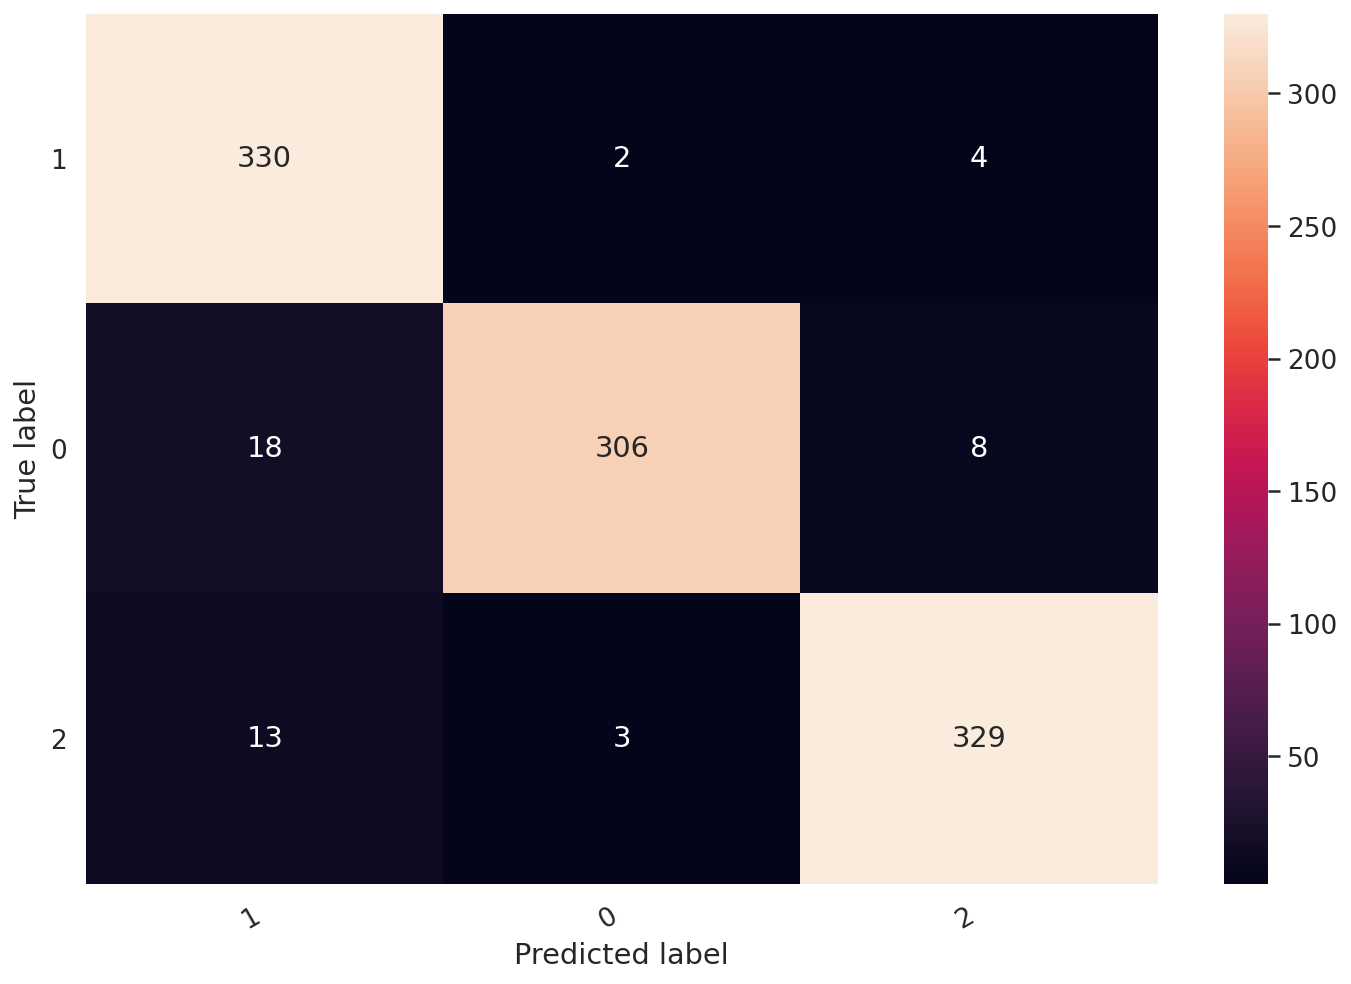

In [43]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [44]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("mBERT: ")
for i in range(kFold):
    print('\n Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=32, shuffle=True,epochs=5)
    train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


212it [00:00, 2105.29it/s]

mBERT: 

 Fold  1



9110it [00:04, 2088.64it/s]
1013it [00:00, 2094.78it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f31040a4c18> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 153s 596ms/step - loss: 0.7590 - acc: 0.7763 - val_loss: 0.6024 - val_acc: 0.9473
Epoch 2/5
257/257 [==============================] - 152s 592ms/step - loss: 0.6115 - acc: 0.9400 - val_loss: 0.5969 - val_acc: 0.9517
Epoch 3/5
257/257 [==============================] - 152s 592ms/step - 

213it [00:00, 2124.88it/s]


 Fold  2



9110it [00:04, 2107.85it/s]
1013it [00:00, 2069.80it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2e33b11048> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 154s 600ms/step - loss: 0.8452 - acc: 0.6751 - val_loss: 0.6172 - val_acc: 0.9319
Epoch 2/5
257/257 [==============================] - 150s 586ms/step - loss: 0.6134 - acc: 0.9378 - val_loss: 0.6085 - val_acc: 0.9407
Epoch 3/5
257/257 [==============================] - 149s 581ms/step - 

210it [00:00, 2096.32it/s]


 Fold  3



9110it [00:04, 2124.70it/s]
1013it [00:00, 2103.91it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2e33b090f0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 154s 600ms/step - loss: 0.8086 - acc: 0.7196 - val_loss: 0.6042 - val_acc: 0.9484
Epoch 2/5
257/257 [==============================] - 150s 585ms/step - loss: 0.6121 - acc: 0.9382 - val_loss: 0.5998 - val_acc: 0.9517
Epoch 3/5
257/257 [==============================] - 149s 581ms/step - 

208it [00:00, 2077.87it/s]


 Fold  4



9110it [00:04, 2143.15it/s]
1013it [00:00, 2062.23it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2e3fbe4e80> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 153s 594ms/step - loss: 0.8501 - acc: 0.6781 - val_loss: 0.6164 - val_acc: 0.9341
Epoch 2/5
257/257 [==============================] - 150s 582ms/step - loss: 0.6293 - acc: 0.9217 - val_loss: 0.6144 - val_acc: 0.9363
Epoch 3/5
257/257 [==============================] - 149s 580ms/step - 

201it [00:00, 2009.41it/s]


 Fold  5



9110it [00:04, 2076.61it/s]
1013it [00:00, 2121.89it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2e351bdb38> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 147s 574ms/step - loss: 0.8051 - acc: 0.7234 - val_loss: 0.6174 - val_acc: 0.9330
Epoch 2/5
257/257 [==============================] - 144s 562ms/step - loss: 0.6106 - acc: 0.9404 - val_loss: 0.6040 - val_acc: 0.9462
Epoch 3/5
257/257 [==============================] - 145s 562ms/step - 

217it [00:00, 2166.42it/s]


 Fold  6



9110it [00:04, 2128.72it/s]
1013it [00:00, 2161.23it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2e3373e5f8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 149s 580ms/step - loss: 0.7645 - acc: 0.7727 - val_loss: 0.6235 - val_acc: 0.9265
Epoch 2/5
257/257 [==============================] - 146s 569ms/step - loss: 0.6089 - acc: 0.9424 - val_loss: 0.6232 - val_acc: 0.9276
Epoch 3/5
257/257 [==============================] - 146s 568ms/step - 

219it [00:00, 2187.60it/s]


 Fold  7



9110it [00:04, 2122.71it/s]
1013it [00:00, 2122.82it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2e3564b5f8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 149s 578ms/step - loss: 0.7665 - acc: 0.7700 - val_loss: 0.6063 - val_acc: 0.9429
Epoch 2/5
257/257 [==============================] - 146s 568ms/step - loss: 0.6219 - acc: 0.9288 - val_loss: 0.6019 - val_acc: 0.9484
Epoch 3/5
257/257 [==============================] - 146s 568ms/step - 

221it [00:00, 2208.17it/s]


 Fold  8



9110it [00:04, 2155.72it/s]
1013it [00:00, 2145.15it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2e327c63c8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 150s 583ms/step - loss: 0.8268 - acc: 0.7065 - val_loss: 0.6375 - val_acc: 0.9111
Epoch 2/5
257/257 [==============================] - 147s 572ms/step - loss: 0.6264 - acc: 0.9236 - val_loss: 0.6140 - val_acc: 0.9374
Epoch 3/5
257/257 [==============================] - 147s 570ms/step - 

220it [00:00, 2196.17it/s]


 Fold  9



9110it [00:04, 2116.30it/s]
1013it [00:00, 2162.61it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f310490cf28> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 152s 593ms/step - loss: 0.7550 - acc: 0.7828 - val_loss: 0.6125 - val_acc: 0.9352
Epoch 2/5
257/257 [==============================] - 149s 580ms/step - loss: 0.6121 - acc: 0.9383 - val_loss: 0.6027 - val_acc: 0.9495
Epoch 3/5
257/257 [==============================] - 150s 582ms/step - 

219it [00:00, 2184.15it/s]


 Fold  10



9110it [00:04, 2077.90it/s]
1013it [00:00, 2075.86it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2e35474e10> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 152s 592ms/step - loss: 0.7371 - acc: 0.8053 - val_loss: 0.5996 - val_acc: 0.9517
Epoch 2/5
257/257 [==============================] - 149s 580ms/step - loss: 0.6118 - acc: 0.9394 - val_loss: 0.5939 - val_acc: 0.9583
Epoch 3/5
257/257 [==============================] - 148s 578ms/step - 

In [45]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9515301085883514
 Mean testing accuracy for 10 folds: 0.9515301048755646


In [49]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
print()
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
print()
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
print()
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

Hindi:  इसलाम सुंदर है
Translated: Islam is beautiful

Hindi:   समाज वादी  पार्टी  जिंदाबाद 
Translated: Samajwadi Party Zindabad

Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂
Translated: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂

text: Islam is beautiful 
Label: 2

text: Samajwadi Party Zindabad 
Label: 2

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 0

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 2



In [48]:

sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
sentences.append(hin_text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
sentences.append(hin_text)

# 2
hin_text =  "'गाजा में दीवाली की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
sentences.append(hin_text)

# 2
hin_text =  "मुस्लिम जेहादी देशद्रोही"
sentences.append(hin_text)


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

text: इसलाम सुंदर है 
Label: 1

text:  समाज वादी  पार्टी  जिंदाबाद  
Label: 0

text: 'गाजा में दीवाली की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂 
Label: 0

text: मुस्लिम जेहादी देशद्रोही 
Label: 2



# Reference

1. Movie Reviews with bert-for-tf2 https://colab.research.google.com/drive/1esTDT7S7-31Uiwr8Hj1meV1aokeo8AYX?authuser=1